# Big Mart Sales Prediction

__Source:__ Data science competition at [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/)

The dataset includes information about 1559 products that were sold in 10 different stores in 2013. There are various attributes that are associated to each product and store. Our goals is to train a predictive model which can predict the future sales of products given both store and item attributes.

**Data science problem:** Predict product sales based on product and store attributes.

Steps of our data science process:

1. Set the research goal: Find out the future sales of products in a particular store
2. Acquire data: Data is available as part of a data science competition
3. Explore data: Basic data exploration
4. Plan strategy: Determine strategies to treat missing data, engineer new features
5. Build pipeline: Build an ML pipeline
6. Build model: Compare different predictive models
7. Present: Report the results

- Resources
- Link to GitHub repo

*Note: I will use a Machine Learning pipeline using the Scikit-learn library. Pipelines allow code reuse and consistence in handling training and test sets.*

## 1. Research goal

The goal is to be able to predict the sales of certain products in particular stores. Such an information is very valuable since we can:
- Notice the fluctuations in product sales and we take actions
- Divert products to stores where they are more popular
- Figure out what attributes are associated with popular products

## 2. Acquire data

Training and test data were downloaded to the working directory from the competition's website.

In [5]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Read file:

In [6]:
train = pd.read_csv("train-file.csv")
test = pd.read_csv("test-file.csv")

## 3. Explore data

Examine file content:

In [7]:
print(train.shape)
display(train.columns.values.reshape((12,1)))

(8523, 12)


array([['Item_Identifier'],
       ['Item_Weight'],
       ['Item_Fat_Content'],
       ['Item_Visibility'],
       ['Item_Type'],
       ['Item_MRP'],
       ['Outlet_Identifier'],
       ['Outlet_Establishment_Year'],
       ['Outlet_Size'],
       ['Outlet_Location_Type'],
       ['Outlet_Type'],
       ['Item_Outlet_Sales']], dtype=object)

There are 6 item (product) attributes, and 5 outlet (store) attibutes. Note that the *Item_Outlet_Sales* is the target variable.

The attribute names are fairly self explanatory. The *Item_Identifier* has unique items for each product, while the *Outlet_Identifier* holds codes regarding the outlets.

Let's take a look at the first few lines to have a general idea about the data types and values:

In [8]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


From the table above, I can see that some of the variables are categorical. A categorical variable's data type is `object`, whereas numerical variables can be `float64` or `int64`. Let's see which variables are categorical:

In [9]:
print('Categorical Variables:')
print('----------------------')
for x in train.dtypes.index:
    if train.dtypes[x]=='object':
        print(x)

Categorical Variables:
----------------------
Item_Identifier
Item_Fat_Content
Item_Type
Outlet_Identifier
Outlet_Size
Outlet_Location_Type
Outlet_Type


I continue to examine data. One of the best ways of seeing the big picture is looking at the number of unique values in a variable and if it has any missing values. I am going to write a custom function that reports that:

In [10]:
def my_summary(df):
    df1 = df.count()
    df2 = df.apply(lambda x: sum(x.isnull()))  # missing values
    df3 = df.apply(lambda x: len(x.unique()))  # missing values

    dfx = pd.concat([df1, df2, df3], axis=1)
    dfx.columns = ['count', 'NaN', 'Unique']
    print(dfx)

In [11]:
my_summary(train)  # Details variables

                           count   NaN  Unique
Item_Identifier             8523     0    1559
Item_Weight                 7060  1463     416
Item_Fat_Content            8523     0       5
Item_Visibility             8523     0    7880
Item_Type                   8523     0      16
Item_MRP                    8523     0    5938
Outlet_Identifier           8523     0      10
Outlet_Establishment_Year   8523     0       9
Outlet_Size                 6113  2410       4
Outlet_Location_Type        8523     0       3
Outlet_Type                 8523     0       4
Item_Outlet_Sales           8523     0    3493


From the above summary, I immediately notice two things:
1. *Item_Weight* and *Outlet_Size* needs to be treated for missing values
2. *Item_Identifier* is a categorical variable, but it has too many unique values. I have to find a way to either transform it to a numerical variable, or somehow reduce its dimensions if I want to use it in my model.

I haven't started cleaning the data yet. I need to take a closer look at the categorical variables to see if they need any treatment before moving on:

In [12]:
cat_var = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 
               'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

for col in cat_var:
    print(train[col].value_counts())
    print('---')

FDW13    10
FDG33    10
FDX20     9
FDV60     9
NCQ06     9
         ..
FDC23     1
FDO33     1
FDN52     1
DRF48     1
FDE52     1
Name: Item_Identifier, Length: 1559, dtype: int64
---
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
---
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
---
OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
-

Again, I can make two important observations:
1. It looks like *Item_Identifier* starts with a 2-letter code and most items start with the same code. We can extract this information and use it in our model.
2. *Item_Fat_Content* has 5 unique values, but it looks like some of them represent the same thing. We need to fix that as well.

Finally, let's take a look at the numerical variables to see if they need any treatment:

In [13]:
num_var = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

train[num_var].head(10)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
0,9.300,0.016047,249.8092,1999
1,5.920,0.019278,48.2692,2009
2,17.500,0.016760,141.6180,1999
3,19.200,0.000000,182.0950,1998
4,8.930,0.000000,53.8614,1987
5,10.395,0.000000,51.4008,2009
6,13.650,0.012741,57.6588,1987
7,NaN,0.127470,107.7622,1985
8,16.200,0.016687,96.9726,2002
9,19.200,0.094450,187.8214,2007


Two things:
1. *Item_Visibility* represent the percent display area of a product. Since all products are visible to some degree, having a 0.0 visibility value doesn't make sense. These entries are probably missing. So, we have to find a way to replace these zeros with more meaningful values.
2. Using outlet's age instead of *Outlet_Establishment_Year* feels more natural.

## 4. Action Plan

At this point, I finally have a plan of action. My data cleaning process will be as follows:
1. Missing data treatment for
    - *Item_Weight*
    - *Item_Visibility*
    - *Outlet_Size*
2. Feature engineering
    - Create an extra feature using codes in the *Item_Identifier*
    - Fix overlapping namings in *Item_Fat_Content*
    - Use establishment's age instead of *Outlet_Establishment_Year*

**One very important note: I am NOT going to include the TEST set in the data cleaning process of the TRAINING set. Once I establish the rules in the TRAINING set, I will use the same rules to treat the TEST set.**

**For example, when treating the missing Item_Weight values the the TEST set, I am NOT going to look at the weight data in the TEST set. Instead, I am going to fill the missing values using the weight data in the TRAINING set.**

### i. Missing data treatment - *Item_Weight*

My approach is simple: If the weight is missing in a particular row, find the *Item_Identifier* in that row. Then, scan the whole data to see if other items with the same identifier have entries in the weight section. If yes, take the mean and plug in. If not, take the mean of all items weights, and plug in.

### ii. Missing data treatment - *Item_Visibility*    

Same approach as above: Find all visibility entries for the same product, take the mean, plug it in as the missing value. If no visibility entry is avaible, take the mean visibility of all items and plug it in.

While we are at it, let's look at the histogram of the visibility data:

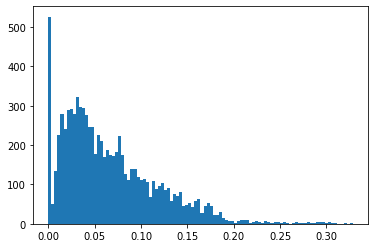

In [14]:
plt.hist(train.Item_Visibility, bins=100);

The distribution is skewed. We are going to take the square root of if to make it more normal.

In [15]:
for outlet in train.Outlet_Identifier.unique():
    print(outlet, train[train.Outlet_Identifier==outlet].Item_Visibility.mean())

OUT049 0.060805543674193545
OUT018 0.06101449825
OUT010 0.10145735520540541
OUT013 0.059956930729613736
OUT027 0.05861472116898396
OUT045 0.060474466806243264
OUT017 0.061376507714902814
OUT046 0.06046438195053763
OUT035 0.06126330468709677
OUT019 0.10844136560227273


Items in OUT010 and OUT019 rated more visible than items in the other stores on avarage.

In [16]:
for outlet in train.Outlet_Type.unique():
    print(outlet, train[train.Outlet_Type==outlet].Item_Visibility.mean())

Supermarket Type1 0.06072282399802762
Supermarket Type2 0.06101449825
Grocery Store 0.10486230210249307
Supermarket Type3 0.05861472116898396


In [17]:
train['Item_Visibility_Rate'] = 'Low'
train.loc[(train.Outlet_Identifier == 'OUT010') | (train.Outlet_Identifier == 'OUT019'), 'Item_Visibility_Rate'] = 'High'

### iii. Missing data treatment - *Outlet_Size*    

Outlet has many other features. Maybe, I can use them to determine the size of outlets which are missing this entry.

I am going to compute a simple cross tabulation of two factors. My goal is to take a look at the relationship between the *Outlet_Size* variable and the others. I am also going to use Chi-square statistics to determine if the relationship is significant.

In [18]:
from scipy.stats import chi2_contingency

# Outlet_Size vs. Outlet_Type
tab = pd.crosstab(train.Outlet_Size, train.Outlet_Type)
chi2, p, dof, ex = chi2_contingency(tab.values, correction=False)
print(tab)
print('Chi2 statistics p-value: ', p)
print('------------------------------------------------------------')

# Outlet_Size vs. Outlet_Location_Type
tab = pd.crosstab(train.Outlet_Size, train.Outlet_Location_Type)
chi2, p, dof, ex = chi2_contingency(tab.values, correction=False)
print(tab)
print('Chi2 statistics p-value: ', p)
print('------------------------------------------------------------')

# Outlet_Size vs. Outlet_Establishment_Year
tab = pd.crosstab(train.Outlet_Size, train.Outlet_Establishment_Year)
chi2, p, dof, ex = chi2_contingency(tab.values, correction=False)
print(tab)
print('Chi2 statistics p-value: ', p)
print('------------------------------------------------------------')

Outlet_Type  Grocery Store  Supermarket Type1  Supermarket Type2  \
Outlet_Size                                                        
High                     0                932                  0   
Medium                   0                930                928   
Small                  528               1860                  0   

Outlet_Type  Supermarket Type3  
Outlet_Size                     
High                         0  
Medium                     935  
Small                        0  
Chi2 statistics p-value:  0.0
------------------------------------------------------------
Outlet_Location_Type  Tier 1  Tier 2  Tier 3
Outlet_Size                                 
High                       0       0     932
Medium                   930       0    1863
Small                   1458     930       0
Chi2 statistics p-value:  0.0
------------------------------------------------------------
Outlet_Establishment_Year  1985  1987  1997  1999  2004  2009
Outlet_Size              

Looks like there is no relationship between *Outlet_Size* and any of the other outlet features. I am going to take a closer look at the *Outlet_Type* and *Outlet_Location_Type* of the missing entries, and try to find a scheme to fill them by using the rest of the data.

In [19]:
tab = pd.crosstab(train[train.Outlet_Size.isnull()].Outlet_Type, train[train.Outlet_Size.isnull()].Outlet_Location_Type)
chi2, p, dof, ex = chi2_contingency(tab.values, correction=False)
print(tab)

Outlet_Location_Type  Tier 2  Tier 3
Outlet_Type                         
Grocery Store              0     555
Supermarket Type1       1855       0


This tells us that the stores with missing Size values are either Grocery Stores with Tier 3 or Supermarket Type 1 with Tier 2. I am going to look at the rest of the data with the same pair combinations and see if they have the Size info avaiable:

In [20]:
train[(~train.Outlet_Size.isnull()) & \
      (train.Outlet_Location_Type == 'Tier 2') & \
      (train.Outlet_Type == 'Supermarket Type1')].Outlet_Size.unique()

array(['Small'], dtype=object)

In [21]:
train[(~train.Outlet_Size.isnull()) & \
      (train.Outlet_Location_Type == 'Tier 3') & \
      (train.Outlet_Type == 'Grocery Store')].Outlet_Size.unique()

array([], dtype=object)

I just figured out two things:
- All Supermarket Type 1 - Tier 2 are Small in size. I will simply fill Small whereever I see this pair
- There are no Grocery Stores - Tier 3 pair in the data. So I can't use the strategy I used above

The only thing I can do at this point is I can look at all the Grocery Stores and see what size shows up the most frequent. Then, I will use that size to fill in the missing values:

In [22]:
train[(~train.Outlet_Size.isnull()) & \
      (train.Outlet_Type == 'Grocery Store')].Outlet_Size.unique()

array(['Small'], dtype=object)

They are all Small size. 

**Strategy:** all of the missing values in the *Outlet_Size* variable will be ***Small***.

### iv. Feature engineering - *Item_Identifier*    

The first two letters in Item_Identifier is a code that shows the category of the item. Let's see what these codes are:

In [23]:
codes = train.Item_Identifier.apply(lambda x: x[:2])
codes.unique()

array(['FD', 'DR', 'NC'], dtype=object)

So, there are 3 unique codes. Just to have an idea, let's see what type of items these codes are asscoiated with:

In [24]:
train[codes == 'FD'].Item_Type.head(5)

0                    Dairy
2                     Meat
3    Fruits and Vegetables
5             Baking Goods
6              Snack Foods
Name: Item_Type, dtype: object

In [25]:
train[codes == 'DR'].Item_Type.head(5)

1     Soft Drinks
18    Hard Drinks
27    Hard Drinks
34    Soft Drinks
37    Soft Drinks
Name: Item_Type, dtype: object

In [26]:
train[codes == 'NC'].Item_Type.head(5)

4              Household
16    Health and Hygiene
22             Household
25             Household
31    Health and Hygiene
Name: Item_Type, dtype: object

It is not necessary to know the names of the categories for model building purposes, but it might be helpful to later interpret the model. For that reason, we are going to name them such that:
- FD: Foods
- DR: Drinks
- NC: Non-consumables

**Strategy**:
- Create a new feature called *Item_Category* and drop *Item_Identifier*.

### v. Feature engineering - *Item_Fat_Content*    

There are actually only two categories in this variable, sometimes the same category is represented by different names. I will fix that: 

**Strategy:**
- Replace 'low fat' and 'LF' with 'Low Fat'
- Replace 'reg' with 'Regular'

### vi. Feature engineering - *Outlet_Establishment_Year*    

Create a new feature called *Outlet_Age* and drop the *Outlet_Establishment_Year*. The data was collected in 2013, so I will use 2013 as the current year.

**Strategy:** 
- Outlet_Age = 2013 - Outlet_Establishment_Year

### vii. Feature engineering - *Item_MRP*    

Plotting the histogram of *Item_MRP* reveals that there are 4 distinct price categories.

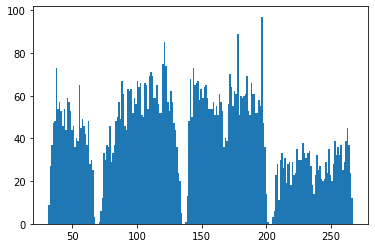

In [27]:
plt.hist(train.Item_MRP, bins=200);
plt.show()

**Strategy:**

I will create a new feauture called *Item_Price_Category* based on the following criteria:
- MRP < 68 : Cheap
- 68 < MRP < 135 : Affordable 
- 135 < MRP < 202 : Pricey 
- MRP > 202 : Expensive 

## 5. Build the pipeline

I am going to write custome transformations which will perform all the actions described above. These transformation will be added to pipeline and both training and test data will be pass through it. All transformers will accept pandas dataframe and return a dataframe. Let's start:

In [28]:
import numpy as np
import pandas as pd
import math
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from collections import defaultdict

The first transformer will be called **SimpleColumnTransformer()** will handle the following tasks:
- Create Item_Category variable
- Fix Fat_Content variable
- Create Outlet_Year variable
- Create Item_Price_Category feature
- Fill Outlet_Size variable

In [29]:
class SimpleColumnTransformer(TransformerMixin):
    '''
    This class will perform 5 transformations. 
    By default, all 5 will be take place, but they can be skipped.
    '''
    def __init__(self, item_id=True, fat_content=True, outlet_year=True, item_mrp=True, outlet_size=True):
        self.item_id = item_id
        self.fat_content = fat_content
        self.outlet_year = outlet_year
        self.item_mrp = item_mrp
        self.outlet_size = outlet_size
        
    def fit(self, X, y=None):  # stateless transformer
        return self

    def transform(self, X):  # assumes X is a DataFrame
        if self.item_id:
            X.loc[:, 'Item_Category'] = np.nan
            codes = X['Item_Identifier'].apply(lambda x: x[:2])
            X.loc[:, 'Item_Category'] = codes
        
        if self.fat_content:
            X.Item_Fat_Content = X.Item_Fat_Content.replace(['low fat', 'LF'], 'Low Fat')
            X.Item_Fat_Content = X.Item_Fat_Content.replace('reg', 'Regular')
        
        if self.outlet_year:
            X.loc[:, 'Outlet_Age'] = 2013 - X.Outlet_Establishment_Year
            X = X.drop('Outlet_Establishment_Year', axis=1)  # drop the redundant column
            
        if self.item_mrp:
            X.loc[:, 'Item_Price_Category'] = np.nan  # create empty column first
            X.loc[X.Item_MRP < 68, 'Item_Price_Category'] = 'Cheap'
            X.loc[(X.Item_MRP > 68) & (X.Item_MRP < 135),'Item_Price_Category'] = 'Affordable'
            X.loc[(X.Item_MRP > 135) & (X.Item_MRP < 202), 'Item_Price_Category'] = 'Pricey'
            X.loc[X.Item_MRP > 202, 'Item_Price_Category'] = 'Expensive'
        
        if self.outlet_size:      
            X.loc[(X.Outlet_Size.isnull()) & \
                  (X.Outlet_Location_Type == 'Tier 2') & \
                  (X.Outlet_Type == 'Supermarket Type1'), 'Outlet_Size'] = 'Small'

            X.loc[(X.Outlet_Size.isnull()) & \
                  (X.Outlet_Location_Type == 'Tier 3') & \
                  (X.Outlet_Type == 'Grocery Store'), 'Outlet_Size'] = 'Small'       
        
        return X

The second transformer will be called **TreatWeight()** and it will treat the missing data in Item_Weigth variable.

In [30]:
class TreatWeight(TransformerMixin):

    def __init__(self):
        self.weights = None

    def fit(self, X, y=None):
        d = defaultdict(int)
        for item in X.Item_Identifier:
            replacement = X[(X.Item_Identifier == item) & (~X.Item_Weight.isnull())].Item_Weight.mean()
            if math.isnan(replacement):
                d[item] = X.Item_Weight.mean().round(2)
            else:
                d[item] = replacement.round(2)
        self.weights = d
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        for index, item in X[X.Item_Weight.isnull()].Item_Identifier.iteritems():
            X.loc[index, 'Item_Weight'] = self.weights[item]
        return X

The third transformer will be called **TreatVisibility()** and it will treat the missing data in Item_Visibility variable and take the square root of it.

In [31]:
class TreatVisibility(TransformerMixin):

    def __init__(self):
        self.visibs = None

    def fit(self, X, y=None):
        d = defaultdict(int)
        for item in X.Item_Identifier:
            replacement = X[(X.Item_Identifier == item) & (X.Item_Visibility != 0.0)].Item_Visibility.mean()
            if math.isnan(replacement):
                d[item] = X.Item_Visibility.mean()
            else:
                d[item] = replacement
        self.visibs = d
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        for index, item in X[X.Item_Visibility == 0.0].Item_Identifier.iteritems():
            X.loc[index, 'Item_Visibility'] = self.visibs[item]
        X.loc[:, 'Item_Visibility'] = np.sqrt(X.Item_Visibility)
        return X

The forth transformer will be called **DummyTransformer()** and it will perform One_Hot encoding.

In [32]:
class DummyTransformer(TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        X = pd.get_dummies(X, drop_first=True)
        return X

The fifth transformer will be called **ZeroOneScaler()** and it will perform Max Min Scaling.

In [33]:
class ZeroOneScaler(TransformerMixin):

    def __init__(self):
        self.mm = None

    def fit(self, X, y=None):
        self.mm = MinMaxScaler()
        self.mm.fit(X)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        X.loc[:,:] = self.mm.transform(X)
        return X

The sixth and final transformer will be called **ColumnExtractor()** and it will return only selected features.

In [34]:
class ColumnExtractor(TransformerMixin):

    def __init__(self, cols):
        # assign columns
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols

**Create the pipeline and fit the training data**

In [35]:
FEATURES = ['Item_Category', 'Item_Weight', 'Item_Fat_Content',
             'Item_Visibility', 'Item_MRP', 'Item_Type', 'Item_Price_Category',
             'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Age']

In [36]:
pipeline = Pipeline([
            ('transform', SimpleColumnTransformer()),
            ('weight', TreatWeight()),
            ('visibility', TreatVisibility()),
            ('extract', ColumnExtractor(FEATURES)),
            ('dummy', DummyTransformer())
        ])

pipeline.fit(train)

Pipeline(memory=None,
         steps=[('transform',
                 <__main__.SimpleColumnTransformer object at 0x123169f98>),
                ('weight', <__main__.TreatWeight object at 0x123169a90>),
                ('visibility',
                 <__main__.TreatVisibility object at 0x123169780>),
                ('extract', <__main__.ColumnExtractor object at 0x1231699b0>),
                ('dummy', <__main__.DummyTransformer object at 0x123169e48>)],
         verbose=False)

Transform the training data:

In [37]:
train_t = pipeline.transform(train)
my_summary(train_t)

                                 count  NaN  Unique
Item_Weight                       8523    0     497
Item_Visibility                   8523    0    8322
Item_MRP                          8523    0    5938
Outlet_Age                        8523    0       9
Item_Category_FD                  8523    0       2
Item_Category_NC                  8523    0       2
Item_Fat_Content_Regular          8523    0       2
Item_Type_Breads                  8523    0       2
Item_Type_Breakfast               8523    0       2
Item_Type_Canned                  8523    0       2
Item_Type_Dairy                   8523    0       2
Item_Type_Frozen Foods            8523    0       2
Item_Type_Fruits and Vegetables   8523    0       2
Item_Type_Hard Drinks             8523    0       2
Item_Type_Health and Hygiene      8523    0       2
Item_Type_Household               8523    0       2
Item_Type_Meat                    8523    0       2
Item_Type_Others                  8523    0       2
Item_Type_Se

See the data after transformations:

In [38]:
train_t.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Age,Item_Category_FD,Item_Category_NC,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Price_Category_Cheap,Item_Price_Category_Expensive,Item_Price_Category_Pricey,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_Medium,Outlet_Size_Small
0,9.30,0.126678,249.8092,14,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
1,5.92,0.138846,48.2692,4,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
2,17.50,0.129461,141.6180,14,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
3,19.20,0.151362,182.0950,15,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,1
4,8.93,0.127139,53.8614,26,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


Transform the test data

In [39]:
test_t = pipeline.transform(test)

## 6. Build the predictive model

I am going to build multiple models and compare them. For this, I am going to split my training data (train_t) into training and validation sets. These sets will be used to evaluate the models' performances.

In [40]:
# The target variable
target = train['Item_Outlet_Sales']

### a. Baseline model

There is no machine learning in Baseline solution. It is just a smart filling method. My strategy is as follows:
- Identify the first item in test set and find its outlet_type and item_type
- Go to training set, find all the instances of the same item having the same outlet_type
- Take their mean. If it is a number, assign it as the prediction.
- If there are no such instances, find the all instances with the same item_type and take their mean. Assign it as the prediction value.

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.33, random_state=42)

In [42]:
from sklearn.base import BaseEstimator

class Baseline_Estimator(BaseEstimator):
    def __init__(self):
        self.predicts = None

    def fit(self, XX, y=None):
        d = defaultdict(int)
        for item in XX.Item_Identifier:
            d[item] = XX[(XX.Item_Identifier == item)].Item_Outlet_Sales.mean()
        self.predicts = d
        return self

    def predict(self, XX):
        # assumes X is a DataFrame
        for index, item in XX.Item_Identifier.iteritems():
            XX.loc[index, 'Item_Outlet_Sales'] = self.predicts[item]
        return XX.Item_Outlet_Sales

**Validation dataset:**

In [43]:
base_model = Baseline_Estimator()
base_model.fit(X_train)
y_pred = base_model.predict(X_val)
print("Baseline RMSE = ", np.sqrt(mean_squared_error(y_val, y_pred)))

Baseline RMSE =  1660.614220132992


**Public dataset:**

In [44]:
# Final model
base_model = Baseline_Estimator()
base_model.fit(train)
test_target = base_model.predict(test)

# Export for submission
test.loc[:, 'Item_Otlet_Sales'] = test_target
output = test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
output.to_csv('baseline_solution.csv', index=False)

After submitting the baseline solution, the score is:

**(Public score) Baseline RMSE = 1598.68** 

I am going to split the transformed training data here. All the upcomming models will use the same set of data.

In [45]:
# Split the transformed data (output of pipeline)
X_train, X_val, y_train, y_val = train_test_split(train_t, target, test_size=0.33, random_state=42)

### b. Linear Regression with Recursive Feature Elimination

In [46]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=3, min_features_to_select=1)

**Validation dataset:**

In [47]:
selector = selector.fit(X_train, y_train)
print('Selected features:')
print(train_t.columns[selector.support_])

Selected features:
Index(['Item_Visibility', 'Item_MRP', 'Outlet_Age', 'Item_Category_FD',
       'Item_Category_NC', 'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Item_Price_Category_Cheap',
       'Item_Price_Category_Expensive', 'Item_Price_Category_Pricey',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Size_Medium',
       'Outlet_Size_Small'],
      dtype='object')


In [48]:
# Predict
y_pred = selector.predict(X_val)
print("Linear Regression with feature elimination RMSE = ", np.sqrt(mean_squared_error(y_val, y_pred)))

Linear Regression with feature elimination RMSE =  1103.6581075533286


In [49]:
# Final model
selector = selector.fit(train_t, target)
test_target = selector.predict(test_t)

# Export
test['Item_Outlet_Sales'] = test_target
output = test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
output.to_csv('lr_rfecv.csv', index=False)

**(Public score) Linear Regression with feature elimination RMSE = 1202.72**

### c. Random Forest with Hyperparameter optimization

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [100, 200, 300, 400, 500, 1000],
    'min_samples_leaf': [1, 2, 4]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

**Validation dataset:**

In [51]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val)
print("RF hyp. opt. RMSE = ", np.sqrt(mean_squared_error(y_val, y_pred)))

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  9.6min finished


RF hyp. opt. RMSE =  1055.1096615622198


In [52]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 400}

In [53]:
features = X_train.columns.values
importances = best_model.feature_importances_

important_features = [features[i] for i, imp in enumerate(importances) if imp > 0.001]
important_features

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Age',
 'Item_Price_Category_Expensive',
 'Item_Price_Category_Pricey',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Size_Medium',
 'Outlet_Size_Small']

In [54]:
# Fit the grid search to the data
rf = RandomForestRegressor(max_depth=5, min_samples_leaf=4, n_estimators=100, random_state=42)
rf.fit(X_train[important_features], y_train)

y_pred = rf.predict(X_val[important_features])
print("RF hyp. opt. w/ feat. sel. RMSE = ", np.sqrt(mean_squared_error(y_val, y_pred)))

RF hyp. opt. w/ feat. sel. RMSE =  1055.9962129317746


(!) Eliminating extra features did not improve.

**Public dataset:**

In [62]:
# Final model
rf.fit(train_t[important_features], target)
test_target = rf.predict(test_t[important_features])

# Export
test['Item_Outlet_Sales'] = test_target
output = test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
output.to_csv('rf_opt.csv', index=False)

**(Public score) Random Forest with hyp. opt. RMSE = 1152.87**

### d. Gradient Boosting (XGBoost)

In [63]:
import xgboost as xgb

In [64]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                max_depth=1, alpha=10, n_estimators=100, booster='gbtree')

for i in range(1,11):
    xg_reg.set_params(max_depth=i)
    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(i)
    print("RMSE: %f" % (rmse))
    print('Test:', r2_score(y_val, y_pred))
    print('Train:', r2_score(y_train, xg_reg.predict(X_train)))

1
RMSE: 1160.838296
Test: 0.5192018616686835
Train: 0.510490531731213
2
RMSE: 1081.850445
Test: 0.5824064528995557
Train: 0.5897337467292103
3
RMSE: 1061.903953
Test: 0.5976631627068683
Train: 0.6222895799344221
4
RMSE: 1061.438149
Test: 0.5980160550685669
Train: 0.6460898298819107
5
RMSE: 1064.835118
Test: 0.5954389629480101
Train: 0.6726656160156788
6
RMSE: 1071.080403
Test: 0.5906795244477605
Train: 0.7083850581879783
7
RMSE: 1079.857821
Test: 0.583943339646801
Train: 0.7463497306484315
8
RMSE: 1088.994996
Test: 0.5768726564960911
Train: 0.7894435645706
9
RMSE: 1098.307415
Test: 0.5696050625078345
Train: 0.8287773376223277
10
RMSE: 1104.393786
Test: 0.5648216992713977
Train: 0.8593659152416984


The optimal max_depth is 4

In [65]:
xg_reg.set_params(max_depth=4);

for i in range(10,110,10):
    xg_reg.set_params(n_estimators=i)
    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(i)
    print("RMSE: %f" % (rmse))
    print('Test:', r2_score(y_val, y_pred))
    print('Train:', r2_score(y_train, xg_reg.predict(X_train)))

10
RMSE: 1453.030478
Test: 0.24669860693426338
Train: 0.21352559650290326
20
RMSE: 1184.415185
Test: 0.4994732915791157
Train: 0.4854732492968412
30
RMSE: 1101.239457
Test: 0.5673040301064218
Train: 0.5666178293774524
40
RMSE: 1075.829013
Test: 0.5870420539082549
Train: 0.5950895173054211
50
RMSE: 1062.367009
Test: 0.5973121985309007
Train: 0.6128186187478392
60
RMSE: 1059.846879
Test: 0.5992204313354104
Train: 0.6222275894074634
70
RMSE: 1059.242399
Test: 0.5996774671664933
Train: 0.6305362795616825
80
RMSE: 1058.777890
Test: 0.6000284971898948
Train: 0.6376172795698607
90
RMSE: 1060.119704
Test: 0.5990140680043802
Train: 0.6410912880921313
100
RMSE: 1061.438149
Test: 0.5980160550685669
Train: 0.6460898298819107


The optimal n_estimators is 80

**Validation dataset:**

In [66]:
xg_reg.set_params(n_estimators=80)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_val)
print("XGBoost RMSE = ", np.sqrt(mean_squared_error(y_val, y_pred)))

XGBoost RMSE =  1058.7778896684076


**Public dataset:**

In [67]:
# Final model
xg_reg.fit(train_t, target)
test_target = xg_reg.predict(test_t)

# Export
test['Item_Outlet_Sales'] = test_target
output = test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
output.to_csv('xgboost.csv', index=False)

**(Public score) XGBoost RMSE = 1152.84**